# Notebook in order to test some machine learning on fitted pulse shapes for TES data

In [8]:
import numpy as np
import os
import glob
import itertools
import matplotlib.pyplot as plt
import copy
from fastespy.plotting import plot_2d_hist, plot_scatter_w_hist
from fastespy.functions import TimeLine, tesresponse, tesresponse_simple, expflare

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

First, we get the data path where the collected results from the pulse shape fit that were read in with `read_result_pulse_shape_triggered.py` are stored.

In [3]:
#path = '../../../data-04202020/dv1p7-all/dvdtthr10_vthr10_steploNone_stepupNone/'
path = '../../../data-04202020/dv1p7-all-expflare/dvdtthr10_vthr10_steploNone_stepupNone/'

Next we read in the `.npy` files and combine the dictionaries they contain:

In [4]:
for i, result_file in enumerate(glob.glob(os.path.join(path, "*.npy"))):
    print (result_file)
    r = np.load(result_file, allow_pickle=True).flat[0]
    if not i:
        result = r
    else:
        for k, v in result.items():
            result[k] = np.append(v, r[k])
            
print ("In total, the files contain {0:n} events".format(result[k].size))
print ("Of which {0:n} are events taken with light".format(np.sum(result['type'] == 0)))
print ("Of which {0:n} are events taken w/o light and no fiber coupled to TES (intrinsic)".format(
    np.sum(result['type'] == 1)))
print ("Of which {0:n} are events taken w/o light and a fiber coupled to TES (extrinsic)".format(
    np.sum(result['type'] == 2)))

../../../data-04202020/dv1p7-all-expflare/dvdtthr10_vthr10_steploNone_stepupNone/intrinsic.npy
../../../data-04202020/dv1p7-all-expflare/dvdtthr10_vthr10_steploNone_stepupNone/extrinsic.npy
../../../data-04202020/dv1p7-all-expflare/dvdtthr10_vthr10_steploNone_stepupNone/light-1.npy
../../../data-04202020/dv1p7-all-expflare/dvdtthr10_vthr10_steploNone_stepupNone/light-2.npy
In total, the files contain 4 events
Of which 4296 are events taken with light
Of which 924 are events taken w/o light and no fiber coupled to TES (intrinsic)
Of which 2966 are events taken w/o light and a fiber coupled to TES (extrinsic)


## Plot the average pulse shape for fits to light data

For this we define a mask for fits to light only and fits that converged and gave a reasonable $\chi^2$

In [5]:
mask = result['type'] == 0  # light data only
mask &= result['fit_ok']  # fit converged
mask &= result['chi2_dof'] <= 1.5

print ("{0:n} / {1:n} fit with light inlcuded".format(mask.sum(), (result['type'] == 0.).sum()))

3954 / 4296 fit with light inlcuded


In [10]:
result['function']

array(['expflare', 'expflare', 'expflare', 'expflare'], dtype='<U8')

In [12]:
from scipy.optimize import curve_fit

In [13]:
curve_fit?

Signature:
curve_fit(
    f,
    xdata,
    ydata,
    p0=None,
    sigma=None,
    absolute_sigma=False,
    check_finite=True,
    bounds=(-inf, inf),
    method=None,
    jac=None,
    **kwargs,
)
Docstring:
Use non-linear least squares to fit a function, f, to data.

Assumes ``ydata = f(xdata, *params) + eps``

Parameters
----------
f : callable
    The model function, f(x, ...).  It must take the independent
    variable as the first argument and the parameters to fit as
    separate remaining arguments.
xdata : array_like or object
    The independent variable where the data is measured.
    Should usually be an M-length sequence or an (k,M)-shaped array for
    functions with k predictors, but can actually be any object.
ydata : array_like
    The dependent data, a length M array - nominally ``f(xdata, ...)``.
p0 : array_like, optional
    Initial guess for the parameters (length N).  If None, then the
    initial values will all be 1 (if the number of parameters for the
    fun

In [14]:
tesresponse_simple?

Signature: tesresponse_simple(t, tol=1e-06, **kwargs)
Docstring: <no docstring>
File:      ~/Python/TESdata/fastespy/fastespy/functions.py
Type:      function


fit results:
8.883 \pm 0.007
1.447 \pm 0.029
3.277 \pm 0.047
19.862 \pm 0.054
-0.163 \pm 0.015
Mean value for tr   : 0.616 +/- 0.385
Mean value for td   : 4.053 +/- 4.159
Mean value for A    : 15.868 +/- 2.021


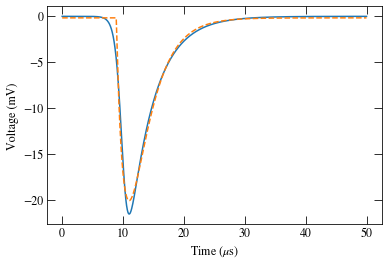

In [27]:
pars = dict(tr = result['tr'][mask].mean(),
            td = result['td'][mask].mean(),
            A = result['amplitude'][mask].mean(),
            c = 0.,
            t0 = 10.
           )

if result['function'][0] == 'expflare':
    f = expflare
elif result['function'][0] == 'tesresponse':
    f = tesresponse
else:
    f = tesresponse_simple

x = np.linspace(0.,50.,2000)
plt.plot(x, f(x, **pars))

# fit the simple tes response to the average pulse
def fit_func(t, t0, tr, td, A, c):
    return tesresponse(t, tr=tr, td=td, t0=t0, A=A, c=c)

popt, pcov = curve_fit(fit_func, x, f(x,**pars),
                       p0=[pars['t0'], pars['tr'], pars['td'], pars['A'], pars['c']]
                      )

plt.plot(x, fit_func(x, *popt), ls='--')
print ("fit results:")
for i, p in enumerate(popt):
    print ("{0:.3f} \pm {1:.3f}".format(p, np.sqrt(pcov[i,i])))

for k, v in pars.items():
    if k == 'c' or k == 't0': continue
    print ("Mean value for {0:5s}: {1:.3f} +/- {2:.3f}".format(
        k, v, np.sqrt(result[k if not k == 'A' else 'amplitude'][mask].var())))

plt.xlabel("Time ($\mu$s)")
plt.ylabel("Voltage (mV)")
plt.savefig("../../../sandbox/plots/avg_pulse.png", dpi=150)

In [19]:
pcov

array([[ 4.24093889e-05, -1.09600205e-04,  1.09813473e-04,
        -8.13040931e-03,  2.99903414e-07],
       [-1.09600205e-04,  8.69523982e-04, -1.26698446e-03,
         7.56763569e-02, -1.29318117e-04],
       [ 1.09813473e-04, -1.26698446e-03,  2.16672587e-03,
        -1.19315195e-01,  2.92009467e-04],
       [-8.13040931e-03,  7.56763569e-02, -1.19315195e-01,
         6.86607361e+00, -1.32807446e-02],
       [ 2.99903414e-07, -1.29318117e-04,  2.92009467e-04,
        -1.32807446e-02,  2.26501435e-04]])

## plot 2d histograms of all possible combinations

First, make a new color map

In [7]:
from matplotlib.colors import ListedColormap

cmap = 'nipy_spectral_r'

cm = plt.cm.get_cmap(cmap, 256)

#step = 25
step = 10
cmin, cmax = 0., 0.7

newcolors = cm(np.linspace(cmin, cmax, 256-25))

# add colors so that last color is white
vals = np.zeros((step, 4))

for i in range(newcolors.shape[1]):
    vals[:,i] = np.linspace(1., newcolors[0,i], step)

newcmp = ListedColormap(np.vstack([vals,newcolors]))
cmap = newcmp

In [8]:
label = dict(
    tr=r'Rise time $(\mu\mathrm{s})$',
    td=r'Decay time $(\mu\mathrm{s})$',
    amplitude=r'Amplitude (mV)',
    integral=r'Pulse Integral (mV $\mu$s)',
    chi2_dof=r'$\chi^2/$d.o.f.'
)

### Plot 2d histograms for photon pulses only in order to see spread of values

Plotting 2d histogram for integral vs amplitude
x=[0.05, 0.95] quantile values are [-184.03 -102.83]
y=[0.05, 0.95] quantile values are [12.67 19.04]
Plotting 2d histogram for integral vs tr
x=[0.05, 0.95] quantile values are [-184.03 -102.83]
y=[0.05, 0.95] quantile values are [0.3  0.92]
Plotting 2d histogram for integral vs td
x=[0.05, 0.95] quantile values are [-184.03 -102.83]
y=[0.05, 0.95] quantile values are [2.5  5.05]
Plotting 2d histogram for integral vs chi2_dof
x=[0.05, 0.95] quantile values are [-184.03 -102.83]
y=[0.05, 0.95] quantile values are [0.73 1.31]
Plotting 2d histogram for amplitude vs tr
x=[0.05, 0.95] quantile values are [12.67 19.04]
y=[0.05, 0.95] quantile values are [0.3  0.92]
Plotting 2d histogram for amplitude vs td
x=[0.05, 0.95] quantile values are [12.67 19.04]
y=[0.05, 0.95] quantile values are [2.5  5.05]
Plotting 2d histogram for amplitude vs chi2_dof
x=[0.05, 0.95] quantile values are [12.67 19.04]
y=[0.05, 0.95] quantile values are [0.73 1.31]
P

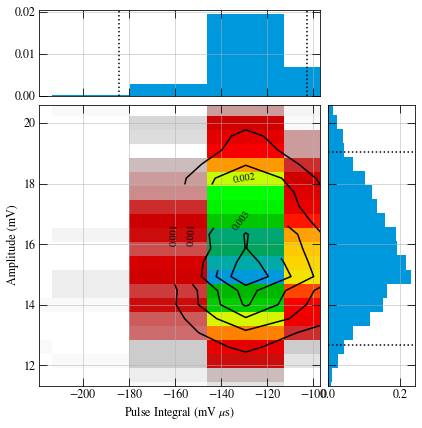

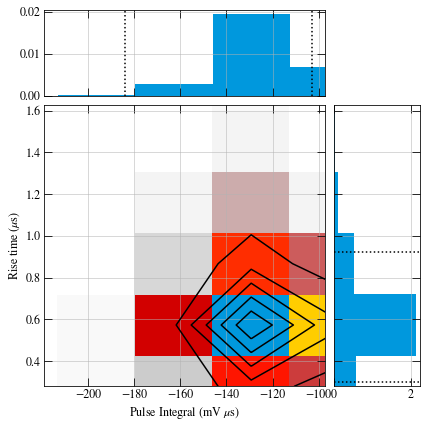

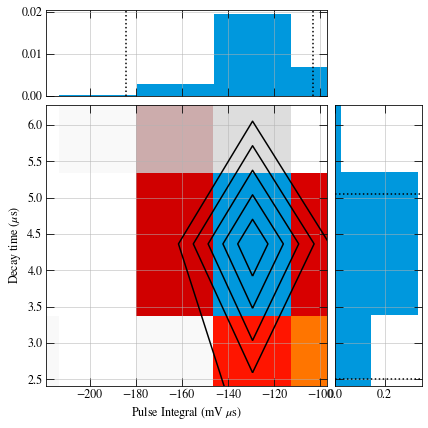

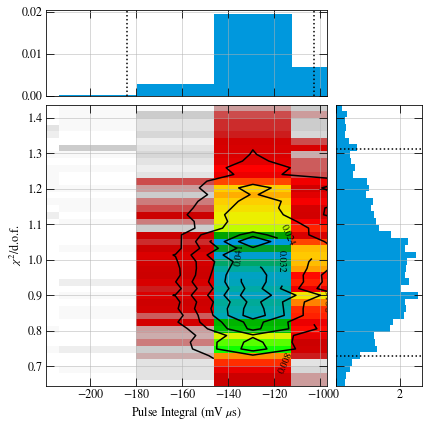

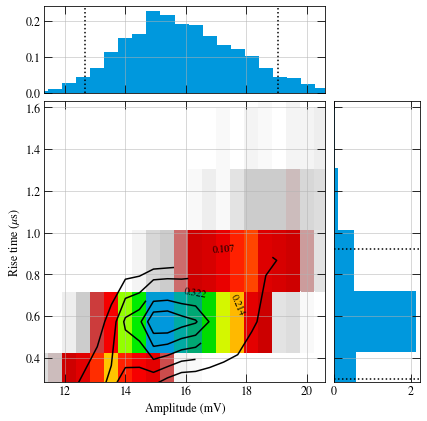

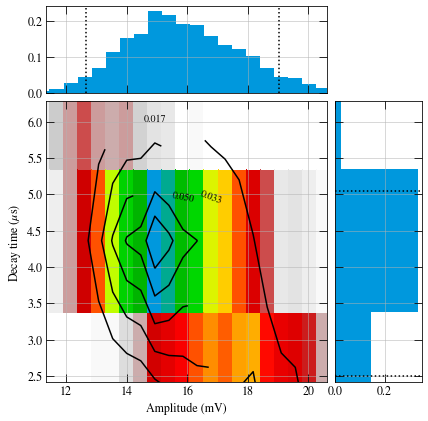

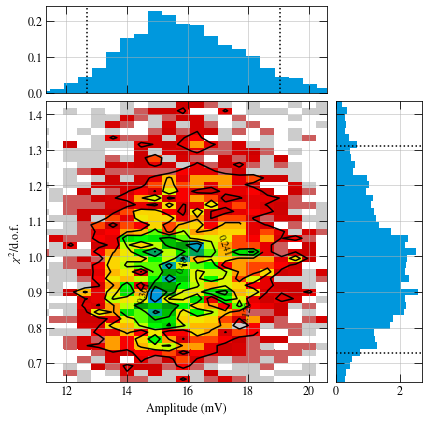

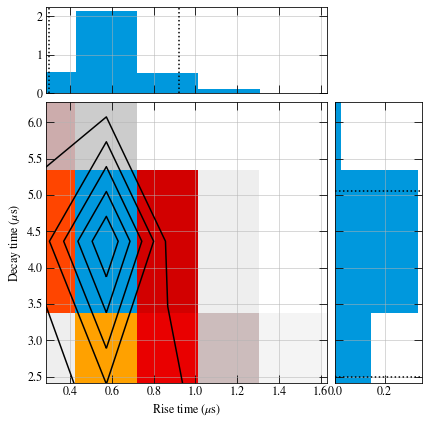

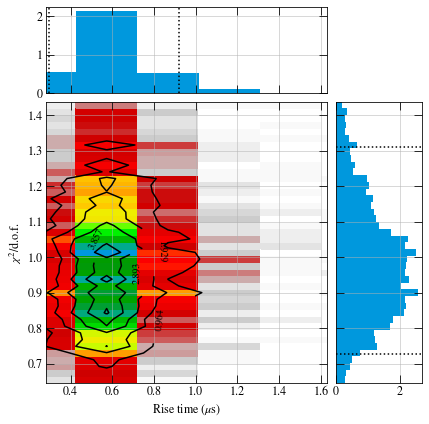

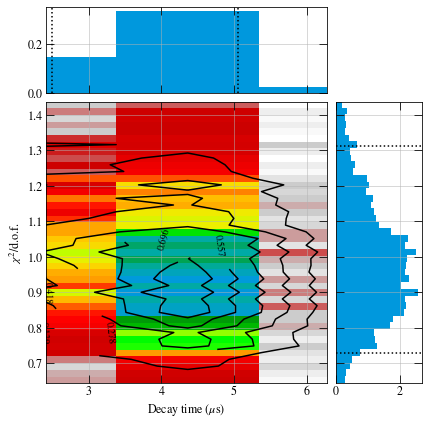

In [9]:
for i, (x, y) in enumerate(itertools.combinations(list(result.keys()), 2)):
    if x == 'chi2' or y == 'chi2' or x == 'dof' or y == 'dof' \
    or x == 'type' or y == 'type' or x == 'fit_ok' or y == 'fit_ok' \
    or x == 'function' or y == 'function':
        continue
    print(f'Plotting 2d histogram for {x} vs {y}')
    fig = plt.figure(i+1, figsize=(6,6))
    for t in range(1):
        m = result['type'] == t
        m &= (result['fit_ok'] & (result['chi2_dof'] < 1.5))
        fig, ax_2d, ax_x, ax_y, bins_x, bins_y = plot_2d_hist(result[x][m], result[y][m],
                                                              fig = fig,
                                                              bins_x=50,
                                                              bins_y=50,
                                                              add_contours=True,
                                                              add_cbar=False,
                                                              quantiles=[0.05,0.95],
                                                              axes_lims=[0.01, 0.99],
                                                              hist_2d_kwargs={"density": True},
                                                              contour_kwargs={"colors": "k"},
                                                              mesh_kwargs={"cmap": cmap},
                                                              hist_x_kwargs={"density": True, "color": cmap(1.)},
                                                              hist_y_kwargs={"density": True, "color": cmap(1.)}
                                                              )
    ax_2d.set_xlabel(label[x])
    ax_2d.set_ylabel(label[y])
    ax_2d.grid(which='both', ls='-', lw='0.5', color='0.7')
    ax_x.grid(which='both', ls='-', lw='0.5', color='0.7')
    ax_y.grid(which='both', ls='-', lw='0.5', color='0.7')
    #fig.subplots_adjust(left=0.1, right=0.6)
    #fig.savefig(os.path.join(path, f'../../../sandbox/plots/scatter_2d_hist_{x}_{y}.png'), dpi=150)
    #plt.close("all")

From the above histograms, define axis limits / bins for scatter plots. These roughly correspond to to two times the 95% quantiles.

In [10]:
n_bins = 50
bins = dict(
                 tr=np.linspace(0., 5., n_bins),
                 td=np.linspace(0., 10., n_bins),
                 integral=np.linspace(-300., -50, n_bins),
                 amplitude=np.linspace(10., 40., n_bins),
                 chi2_dof=np.linspace(0.5, 3., n_bins)
)

Now we plot scatter plots: light and intrinsic, light vs all. 

In [11]:
label_points = ['light', 'intrinsic', 'extrinsic']

Plotting 2d scatter plots for integral vs amplitude
Plotting 2d scatter plots for integral vs tr


/Users/manuelmeyer/Python/TESdata/fastespy/fastespy/plotting.py:317: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax_2d = plt.axes(rect_scatter)
/Users/manuelmeyer/Python/TESdata/fastespy/fastespy/plotting.py:318: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax_x = plt.axes(rect_histx)
/Users/manuelmeyer/Python/TESdata/fastespy/fastespy/plotting.py:319: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a

Plotting 2d scatter plots for integral vs td
Plotting 2d scatter plots for integral vs chi2_dof
Plotting 2d scatter plots for amplitude vs tr
Plotting 2d scatter plots for amplitude vs td
Plotting 2d scatter plots for amplitude vs chi2_dof
Plotting 2d scatter plots for tr vs td
Plotting 2d scatter plots for tr vs chi2_dof
Plotting 2d scatter plots for td vs chi2_dof


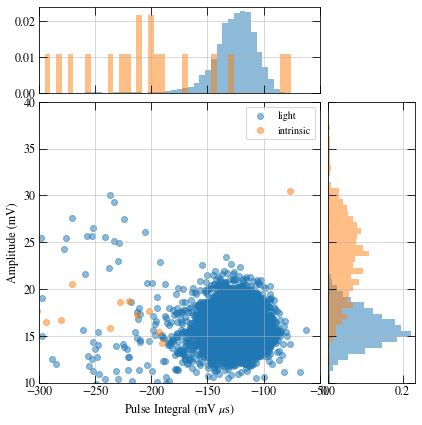

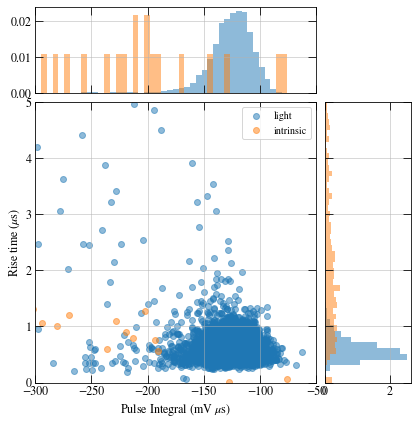

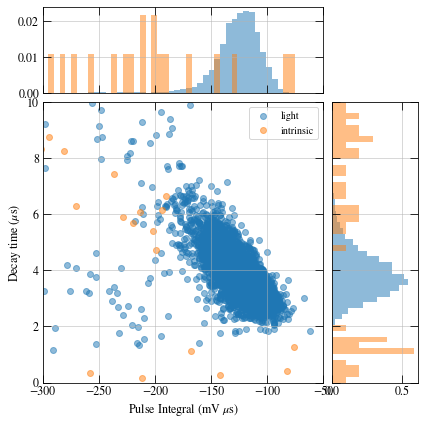

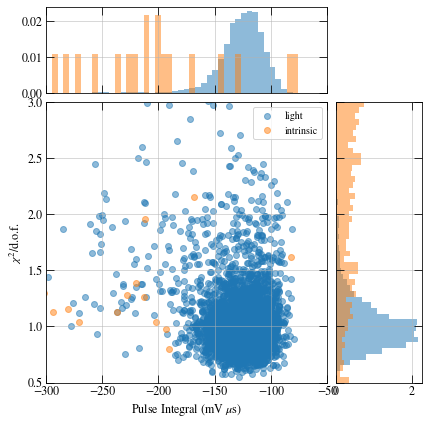

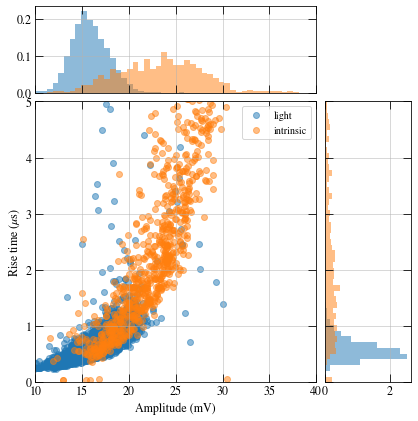

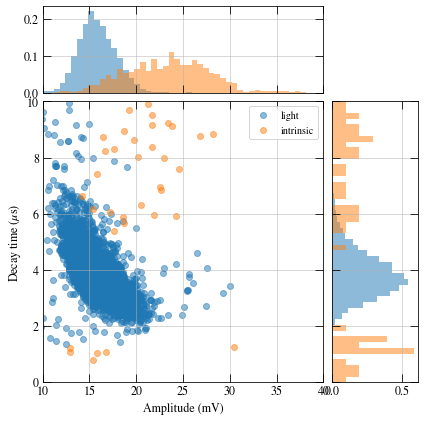

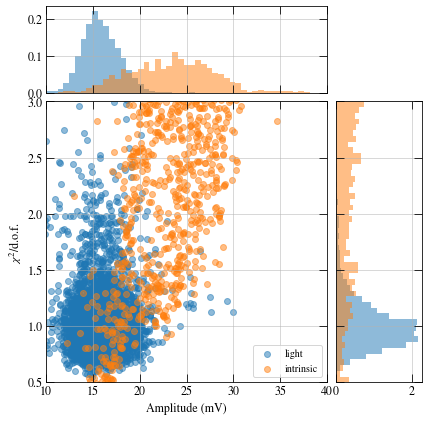

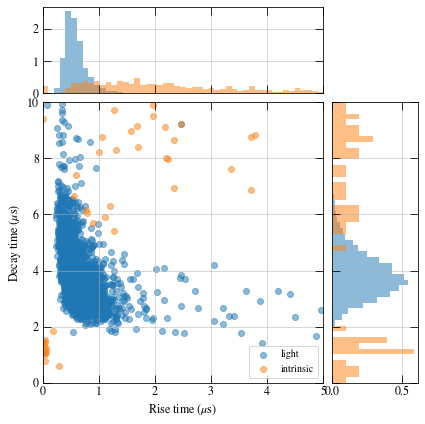

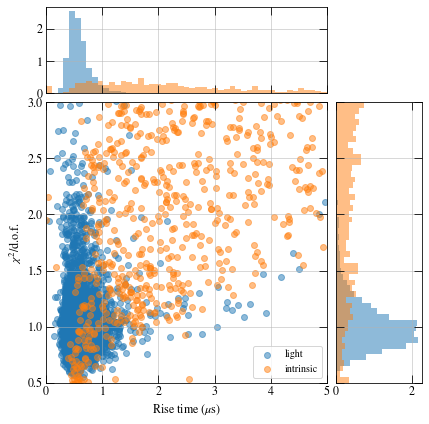

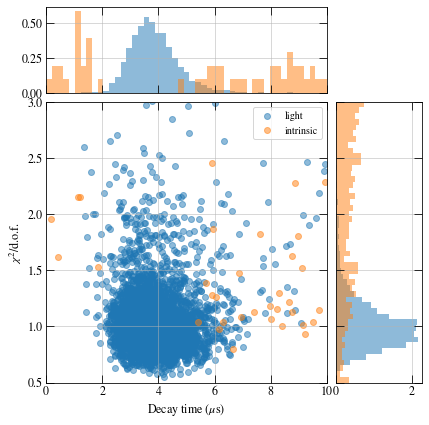

In [12]:
for i, (x, y) in enumerate(itertools.combinations(list(result.keys()), 2)):
    if x == 'chi2' or y == 'chi2' or x == 'dof' or y == 'dof' \
    or x == 'type' or y == 'type' or x == 'fit_ok' or y == 'fit_ok' \
    or x == 'function' or y == 'function':
        continue
    print(f'Plotting 2d scatter plots for {x} vs {y}')
    fig = plt.figure(i+1, figsize=(6,6))
    for t in range(2):
        m = result['type'] == t
        fig, ax_2d, ax_x, ax_y, bins_x, bins_y = plot_scatter_w_hist(result[x][m], result[y][m],
                                                                     bins_x=bins[x],
                                                                     bins_y=bins[y],
                                                                     fig=fig,
                                                                     #bins_x=100,
                                                                     #bins_y=100,
                                                                     scatter_kwargs={"marker": 'o',
                                                                                     "alpha": 0.5,
                                                                                     "label": label_points[t]
                                                                                    },
                                                                     hist_x_kwargs={"density": True, "alpha": 0.5},
                                                                     hist_y_kwargs={"density": True, "alpha": 0.5}
                                                                    )
    ax_2d.set_xlabel(label[x])
    ax_2d.set_ylabel(label[y])
    ax_2d.legend()
    ax_2d.grid(which='both', ls='-', lw='0.5', color='0.7')
    ax_x.grid(which='both', ls='-', lw='0.5', color='0.7')
    ax_y.grid(which='both', ls='-', lw='0.5', color='0.7')
    
    ax_2d.set_xlim(bins[x].min(), bins[x].max())
    ax_2d.set_ylim(bins[y].min(), bins[y].max())
    ax_x.set_xlim(ax_2d.get_xlim())
    ax_y.set_ylim(ax_2d.get_ylim())
    
    #fig.savefig(os.path.join("../../../sandbox/plots", f'scatter_2d_hist_{x}_{y}_light+intrinsic.png'), dpi=150)
    #plt.close("all")

Plotting 2d scatter plots for integral vs amplitude
Plotting 2d scatter plots for integral vs tr
Plotting 2d scatter plots for integral vs td
Plotting 2d scatter plots for integral vs chi2_dof
Plotting 2d scatter plots for amplitude vs tr
Plotting 2d scatter plots for amplitude vs td
Plotting 2d scatter plots for amplitude vs chi2_dof
Plotting 2d scatter plots for tr vs td
Plotting 2d scatter plots for tr vs chi2_dof
Plotting 2d scatter plots for td vs chi2_dof


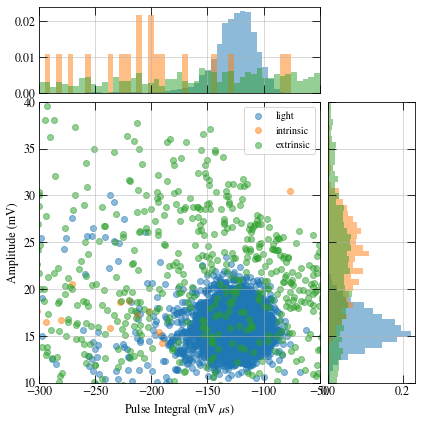

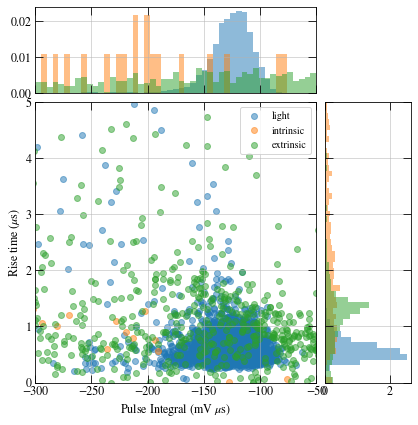

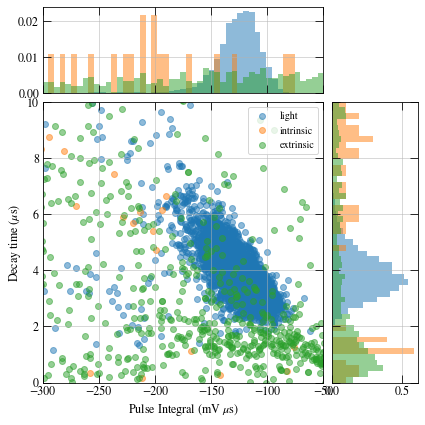

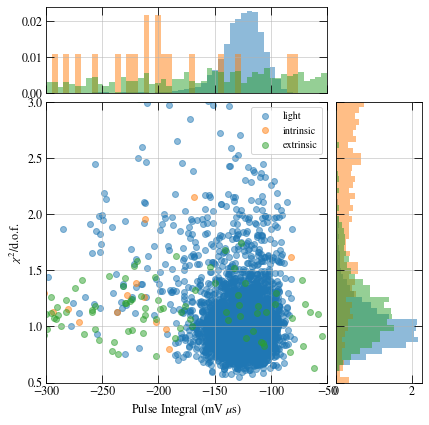

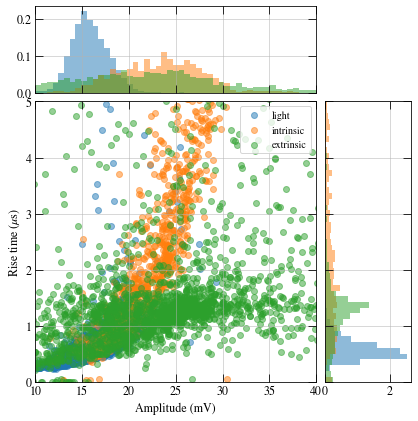

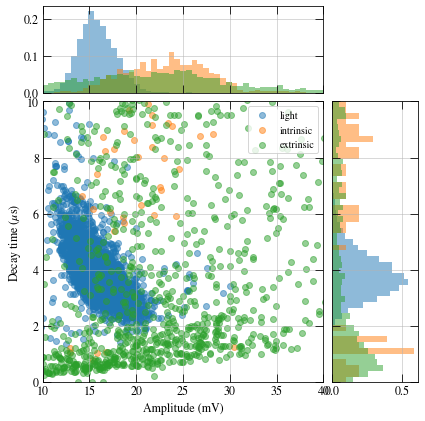

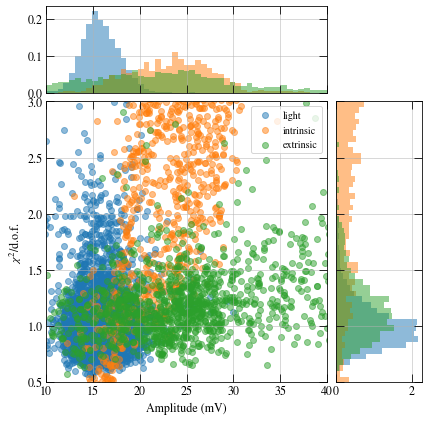

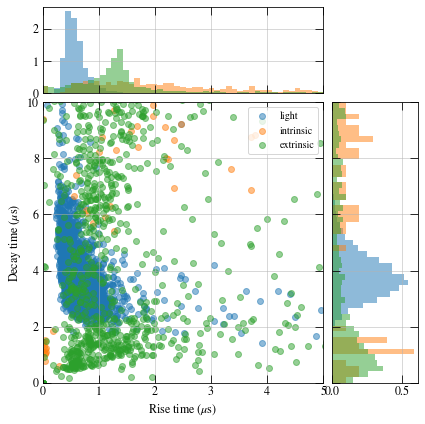

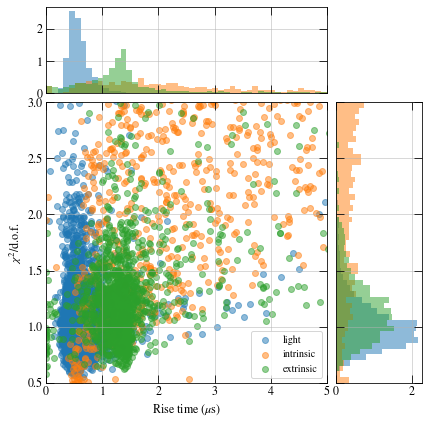

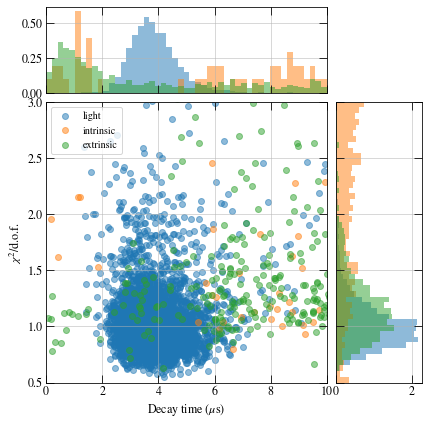

In [13]:
for i, (x, y) in enumerate(itertools.combinations(list(result.keys()), 2)):
    if x == 'chi2' or y == 'chi2' or x == 'dof' or y == 'dof' \
    or x == 'type' or y == 'type' or x == 'fit_ok' or y == 'fit_ok' \
    or x == 'function' or y == 'function':
        continue
    print(f'Plotting 2d scatter plots for {x} vs {y}')
    fig = plt.figure(i+1, figsize=(6,6))
    for t in range(3):
        m = result['type'] == t
        fig, ax_2d, ax_x, ax_y, bins_x, bins_y = plot_scatter_w_hist(result[x][m], result[y][m],
                                                                     bins_x=bins[x],
                                                                     bins_y=bins[y],
                                                                     fig=fig,
                                                                     #bins_x=100,
                                                                     #bins_y=100,
                                                                     scatter_kwargs={"marker": 'o',
                                                                                     "alpha": 0.5,
                                                                                     "label": label_points[t]
                                                                                    },
                                                                     hist_x_kwargs={"density": True, "alpha": 0.5},
                                                                     hist_y_kwargs={"density": True, "alpha": 0.5}
                                                                    )
    ax_2d.set_xlabel(label[x])
    ax_2d.set_ylabel(label[y])
    ax_2d.legend()
    ax_2d.grid(which='both', ls='-', lw='0.5', color='0.7')
    ax_x.grid(which='both', ls='-', lw='0.5', color='0.7')
    ax_y.grid(which='both', ls='-', lw='0.5', color='0.7')
    
    ax_2d.set_xlim(bins[x].min(), bins[x].max())
    ax_2d.set_ylim(bins[y].min(), bins[y].max())
    ax_x.set_xlim(ax_2d.get_xlim())
    ax_y.set_ylim(ax_2d.get_ylim())
    
    #fig.savefig(os.path.join("../../../sandbox/plots", f'scatter_2d_hist_{x}_{y}_light+all.png'), dpi=150)
    #plt.close("all")

From these scatter plots it seems that:

* $\chi^2$ vs Amplitude and $\chi^2$ vs pulse integral seems to be good discriminators
* rise time vs decay time also seem to be doing ok
* Pulse integral vs. amplitude only good for separating light from intrinsic background

## Separating classes with simple decision tree

First import the decision tree classes 

In [14]:
from sklearn import tree
from sklearn.model_selection import train_test_split

Build a data vector `X` which has the size `n_samples x n_features`

In [15]:
features = ['integral', 'amplitude', 'tr', 'td', 'chi2_dof']
X = np.zeros((result['type'].size, len(features)))
y = copy.deepcopy(result['type'])

for i, k in enumerate(features):
    X[:,i] = copy.deepcopy(result[k])

If we only want to look at separating light from intrinsic background, we define a mask `m`:

In [16]:
# light vs intrinsic
#m = result['type'] < 2
#class_labels = ['light', 'intrinsic']
#prefix_plot = 'light_vs_int'
#collection_time_s = 7. * 24. * 3600.


# light vs all
#m = np.ones(result['type'].size, dtype=np.bool) 
#y[y > 1] = 1
#class_labels = ['light', 'background']
#prefix_plot = 'light_vs_all'
#collection_time_s = 1. * 24. * 3600.  # data taking time in s

# light vs extrinsic
m = (result['type'] == 0) | (result['type'] == 2)
y[y > 1] = 1
class_labels = ['light', 'extrinsic']
prefix_plot = 'light_vs_extrinsic'
collection_time_s = 24. * 3600.  # data taking time in s


We separate the data into training and test samples, simply be drawing samples randomly (without stratifying for now).

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X[m], y[m], 
                                                    random_state=42, 
                                                    stratify=None,
                                                    test_size=0.33
                                                   )
print (X_train.shape, y_train.shape)

(4865, 5) (4865,)


In [18]:
dt = tree.DecisionTreeClassifier(criterion='gini', # gini is default
                                  # termination criteria, the default settings give you the full tree:
                                 min_samples_split = 2, # 2 is default 
                                 min_samples_leaf = 1, # 1 is default
                                 max_depth = None, # None is default
                                 random_state = 0
                                 )

In [19]:
fit = dt.fit(X_train, y_train)

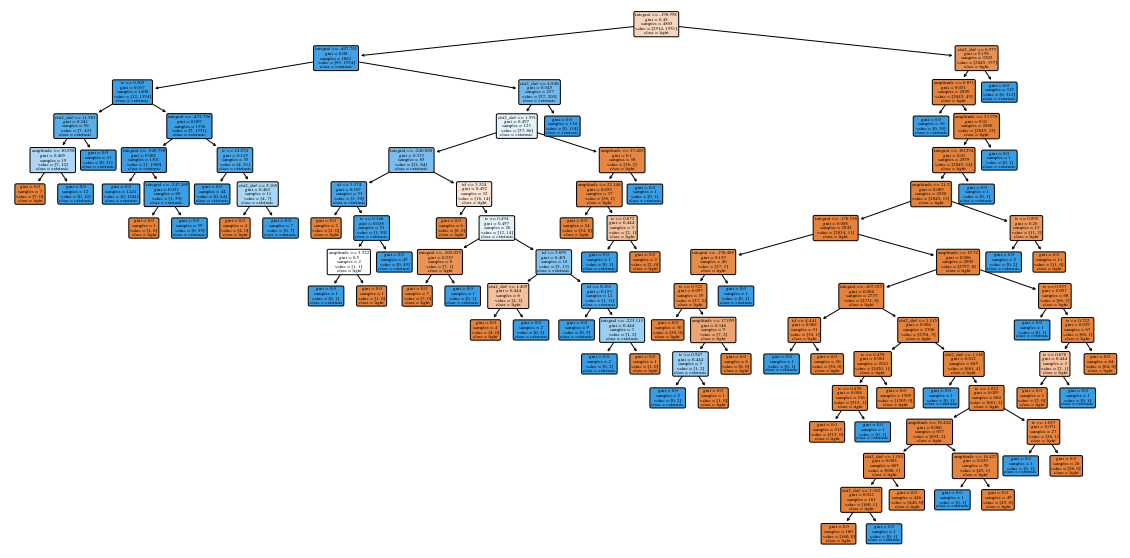

In [20]:
plt.figure(figsize = (20,10))
_ = tree.plot_tree(fit,
                   feature_names=features,  
                   class_names=class_labels,  
                   filled=True, rounded=True)
plt.savefig(f"full_tree_{prefix_plot:s}.pdf")

Now we prune this fully grown tree with a regularization parameter $\alpha$ that penalizes ever more complex trees.

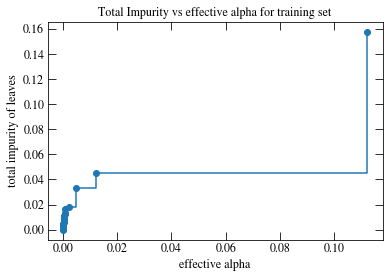

In [21]:
path = dt.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")
plt.savefig(f"impurity_vs_alpha_{prefix_plot:s}.png")

Train new trees with different values of $\alpha$

In [22]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = tree.DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
      clfs[-1].tree_.node_count, ccp_alphas[-1]))

Number of nodes in the last tree is: 1 with ccp_alpha: 0.3228204297206543


See how trees change with changing $\alpha$

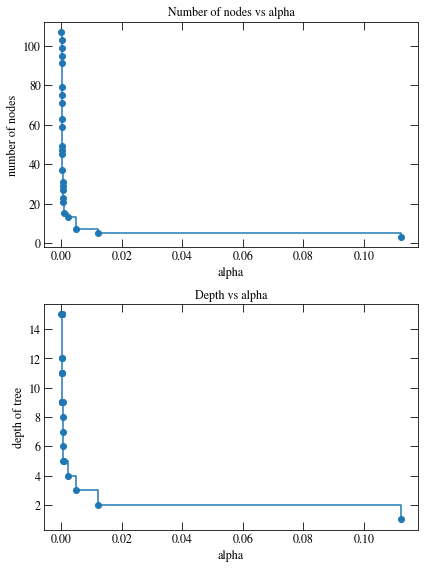

In [23]:
# Solution part 3:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1, figsize = (6,8))
ax[0].plot(ccp_alphas, node_counts, marker='o', drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker='o', drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()
fig.savefig(f"tree_vs_alpha_{prefix_plot:s}.png")

See how the test and training accuracy evolve with $\alpha$, where the accuracy is defined as:

$$
\mathrm{accuracy} = \frac{\#\mathrm{correctly~classified~samples}}{\#\mathrm{samples}}.
$$

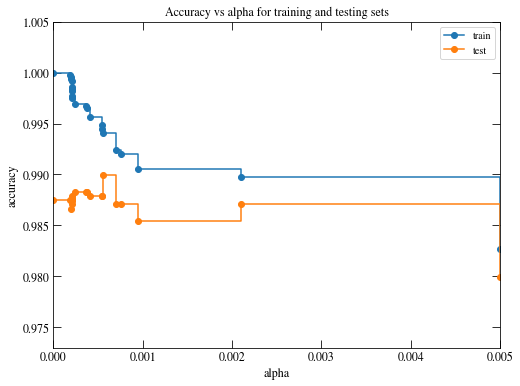

In [24]:
# Solution part 4:
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

fig, ax = plt.subplots(figsize = (8,6))
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
ax.set_ylim(0.973, 1.005)
ax.set_xlim(-0.00, 0.005)
fig.savefig(f"accuracy_vs_alpha_{prefix_plot:s}.png")

Lastly, plot the tree with the highest test scores:

16 0.9899874843554443
0.0005595523581135093


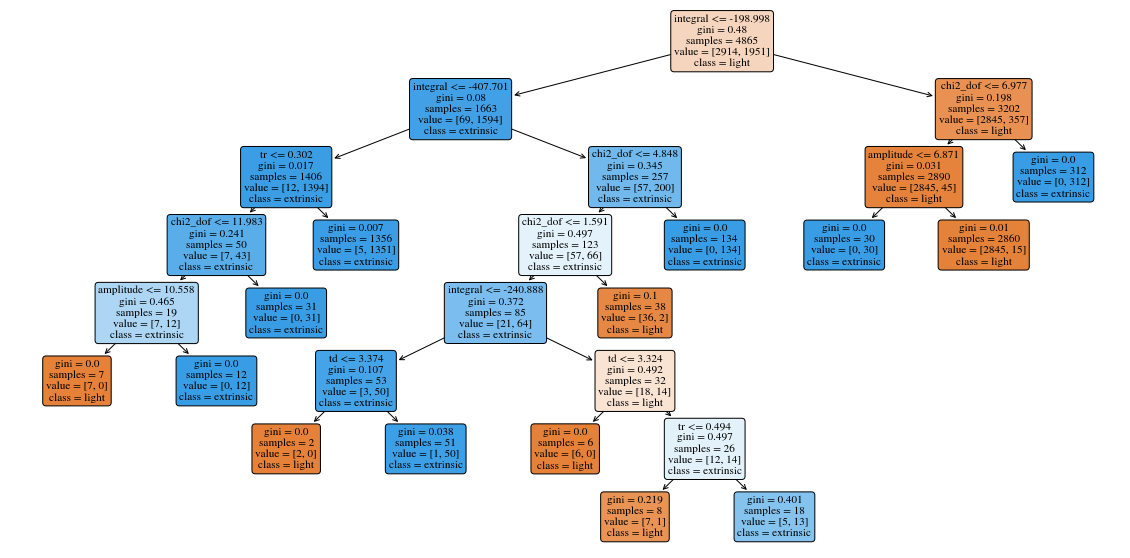

In [25]:
# Solution:
idx = np.argmax(test_scores)
clf_best = clfs[idx]

print (idx, test_scores[idx])
print (ccp_alphas[idx])

plt.figure(figsize = (20,10))
_ = tree.plot_tree(clf_best.fit(X_train, y_train),
                   feature_names=features,  
                   class_names=class_labels,  
                   filled=True, rounded=True)
plt.savefig(f"pruned_tree_{prefix_plot:s}.pdf")

And finally, get the number of background events in test sample falsely classified as light:

In [26]:
p_missclass = 1. - clf_best.score(X_test[y_test > 0], y_test[y_test > 0])
print (p_missclass)

0.011822660098522175


In [27]:
"Background rate DT: {0:.4e} Hz".format(np.sum(y_test > 0) * p_missclass / collection_time_s)

'Background rate DT: 1.3889e-04 Hz'

### Try a boosted decision tree

In [28]:
from sklearn.ensemble import GradientBoostingClassifier

In [29]:
params = {'n_estimators': 1000,
          'max_leaf_nodes': None,
          'max_depth': 3,
          'random_state': 2,
          'min_samples_split': 2,
          'learning_rate': 0.1,
          'subsample': 0.5
         }

In [30]:
bdt = GradientBoostingClassifier(**params)

In [31]:
bdt.fit(X_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=1000,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=2, subsample=0.5, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [32]:
test_deviance = np.zeros((params['n_estimators'],), dtype=np.float64)

In [33]:
for i, y_pred in enumerate(bdt.staged_decision_function(X_test)):
    # clf.loss_ assumes that y_test[i] in {0, 1}
    test_deviance[i] = bdt.loss_(y_test, y_pred)

Text(0, 0.5, 'Test Set Deviance')

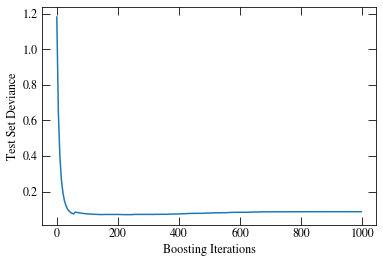

In [34]:
plt.plot((np.arange(test_deviance.shape[0]) + 1)[::5],
         test_deviance[::5],
         '-')
plt.xlabel('Boosting Iterations')
plt.ylabel('Test Set Deviance')

In [35]:
"Background rate BDT: {0:.4e} Hz".format(np.sum(y_test > 0) * (1. - bdt.score(X_test[y_test > 0], y_test[y_test > 0])) \
                                     / collection_time_s)

'Background rate BDT: 1.2731e-04 Hz'

### Try a random forest

In [36]:
from sklearn.ensemble import RandomForestClassifier

In [37]:
rf = RandomForestClassifier(n_estimators=10,
                            max_depth=None,
                            min_samples_split=2,
                            random_state=0)

In [38]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [39]:
"Background rate RF: {0:.4e} Hz".format(np.sum(y_test > 0) * (1. - rf.score(X_test[y_test > 0], y_test[y_test > 0])) \
                                     / collection_time_s)

'Background rate RF: 1.2731e-04 Hz'

### Try a support Vector Classifier

In [40]:
from sklearn import svm

In [41]:
svc = svm.SVC(C=1.e-1,
              #kernel='poly',
              kernel='rbf',
              degree=4,
              gamma='scale',
              coef0=1.,
             )

In [42]:
svc.fit(X_train, y_train)

SVC(C=0.1, break_ties=False, cache_size=200, class_weight=None, coef0=1.0,
    decision_function_shape='ovr', degree=4, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [43]:
"Background rate SVC: {0:.4e} Hz".format(np.sum(y_test > 0) * (1. - svc.score(X_test[y_test > 0], y_test[y_test > 0])) \
                                     / collection_time_s)

'Background rate SVC: 3.5995e-03 Hz'

### Try a deep neural network aka multi-layer perceptron 

In [44]:
from sklearn.neural_network import MLPClassifier

In [45]:
mlp = MLPClassifier(hidden_layer_sizes=(30,30),
                    activation='relu',
                    solver='adam',
                    alpha=1e-4,
                    learning_rate='constant',
                    learning_rate_init=1e-3,
                    random_state=2
                   )

In [46]:
mlp.fit(X_train, y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(30, 30), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=2, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [47]:
"Background rate MLP: {0:.4e} Hz".format(np.sum(y_test > 0) * (1. - mlp.score(X_test[y_test > 0], y_test[y_test > 0])) \
                                     / collection_time_s)

'Background rate MLP: 4.8611e-04 Hz'

# Do a comparison between BDT, RF, and a simple decision tree using Cross Validation, learning curves, and ROC curves

In [48]:
dt = tree.DecisionTreeClassifier(criterion='gini', # gini is default
                                  # termination criteria, the default settings give you the full tree:
                                 min_samples_split = 2, # 2 is default 
                                 min_samples_leaf = 1, # 1 is default
                                 max_depth = 3, # None is default
                                 random_state = 0
                                 )

params = {'n_estimators': 1000,
          'max_leaf_nodes': None,
          'max_depth': 3,
          'random_state': 2,
          'min_samples_split': 2,
          'learning_rate': 0.1,
          'subsample': 0.5
         }
bdt = GradientBoostingClassifier(**params)

rf = RandomForestClassifier(n_estimators=10,
                            max_depth=None,
                            min_samples_split=2,
                            random_state=0)

clfs = [dt, bdt, rf]
label_clf = ['DT', 'BDT', 'RF']

In [49]:
for clf in clfs:
    clf.fit(X_train, y_train)

Illustrate decision tree. It's score is given by it's accuracy, 
$$
\mathrm{accuracy} = \frac{\#\mathrm{correctly~classified~samples}}{\#\mathrm{samples}}.
$$

In [50]:
score = dt.score(X_test, y_test)
print ("Accuracy: {0:.5f}".format(score))
print ("Misclassification: {0:.5e}".format(1. - score))
print ("Background rate DT: {0:.4e} Hz".format(np.sum(y_test > 0) * \
                                               (1. - dt.score(X_test[y_test > 0], y_test[y_test > 0])) \
                                                / collection_time_s))

Accuracy: 0.97997
Misclassification: 2.00250e-02
Background rate DT: 1.1574e-04 Hz


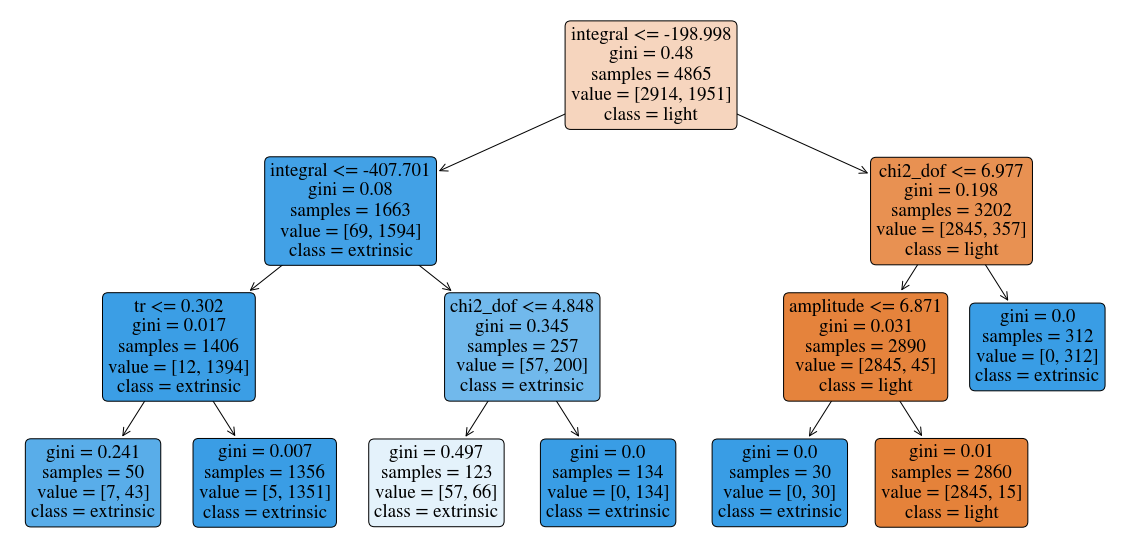

In [51]:
plt.figure(figsize = (20,10))
_ = tree.plot_tree(dt.fit(X_train, y_train),
                   feature_names=features,  
                   class_names=class_labels,  
                   filled=True, rounded=True)
plt.savefig(f"../../../sandbox/plots/pruned_tree_{prefix_plot:s}.pdf")

Do cross validation

In [52]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit

In [53]:
scores = []
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
np.set_printoptions(precision=8)
for i, clf in enumerate(clfs):
    scores.append(cross_val_score(clf, X_train, y_train, cv=cv))
scores = np.array(scores)

Text(0, 0.5, 'Accuracy')

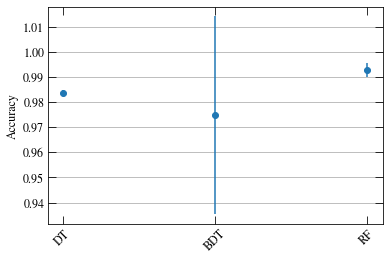

In [54]:
plt.errorbar(range(scores.shape[0]), scores.mean(axis=1),
             yerr=np.sqrt(scores.var(axis=1)),
             marker='o', ls='none'
            )
plt.grid(axis='y')
plt.xticks([0,1,2],['DT','BDT','RF'], rotation=45.)
plt.ylabel('Accuracy')

In [55]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=0)

accuracy = []
bkg_rate = []
for i, clf in enumerate(clfs):
    accuracy.append([])
    bkg_rate.append([])
    
    print (i)
    for train_index, test_index in kf.split(X[m]):
        X_train, X_test = X[m][train_index], X[m][test_index]
        y_train, y_test = y[m][train_index], y[m][test_index]
        
        clf.fit(X_train, y_train)
        
        accuracy[-1].append(clf.score(X_test, y_test))
        bkg_rate[-1].append(np.sum(y_test > 0) * (1. - clf.score(X_test[y_test > 0], y_test[y_test > 0])) \
                                     / collection_time_s)
        
accuracy = np.array(accuracy)
bkg_rate = np.array(bkg_rate)

0
1
2


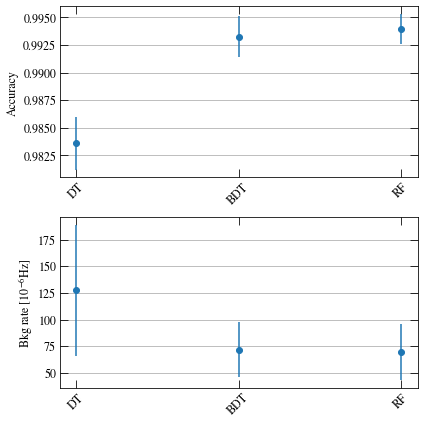

In [56]:
fig = plt.figure(figsize=(6,6), tight_layout=True)

for i, a in enumerate([accuracy, bkg_rate]):

    ax = plt.subplot(2,1,i+1)
    
    c = 1. if not i else 1e6

    plt.errorbar(range(a.shape[0]), a.mean(axis=1) * c,
                 yerr=np.sqrt(a.var(axis=1)) * c,
                 marker='o', ls='none'
                )
    plt.grid(axis='y')
    plt.xticks([0,1,2],['DT','BDT','RF'], rotation=45.)
    plt.ylabel('Accuracy' if not i else 'Bkg rate [$10^{-6}$Hz]')
    
plt.savefig(f"../../../sandbox/plots/accuracy_bkg_rate_{prefix_plot:s}.pdf")

### Learning curve

In [57]:
from sklearn.model_selection import learning_curve

In [58]:
train_sizes = (np.arange(0.1,0.9,0.1) * y[m].shape).astype(np.int)

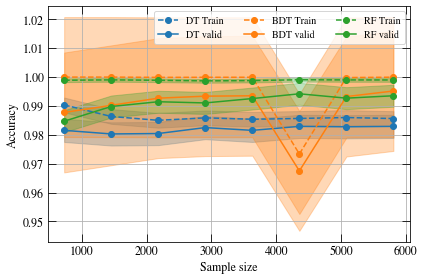

In [59]:
fig = plt.figure(figsize=(6,4), tight_layout=True)

color_train = [plt.cm.tab20(0.1 * i) for i in range(len(clfs) * 2)]
color_valid = [plt.cm.tab20(0.1 * i) for i in range(len(clfs) * 2)]
for i, clf in enumerate(clfs):
    train_sizes, train_scores, valid_scores = learning_curve(clf, X[m], y[m],
                                                             train_sizes=train_sizes,
                                                             cv=cv)
    
    plt.plot(train_sizes, train_scores.mean(axis=1),
             marker='o', label=label_clf[i] + " Train", ls='--',
             color=color_train[i]
            )
    plt.fill_between(train_sizes,
                     train_scores.mean(axis=1) - np.sqrt(train_scores.var()),
                     y2=train_scores.mean(axis=1) + np.sqrt(train_scores.var()),
                     alpha=0.3, color=color_train[i], zorder=-1
                    )
    
    plt.plot(train_sizes, valid_scores.mean(axis=1),
             marker='o', label=label_clf[i] + " valid", ls='-',
             color=color_valid[i]
            )
    plt.fill_between(train_sizes,
                     valid_scores.mean(axis=1) - np.sqrt(valid_scores.var()),
                     y2=valid_scores.mean(axis=1) + np.sqrt(valid_scores.var()),
                     alpha=0.3, color=color_valid[i], zorder=-1
                    )

plt.grid()
plt.xlabel("Sample size")
plt.ylabel("Accuracy")
plt.legend(ncol=3)
plt.savefig(f"../../../sandbox/plots/learning_curve_{prefix_plot:s}.pdf")

### ROC Curve

In [60]:
from sklearn.metrics import roc_curve, roc_auc_score

In [61]:
kf = KFold(n_splits=5, shuffle=True, random_state=0)
fpr, tpr, thr = [], [], []
roc_auc = []

for i, clf in enumerate(clfs):
    
    fpr.append([])
    tpr.append([])
    thr.append([])
    roc_auc.append([])
    
    for train_index, test_index in kf.split(X[m]):
        
        X_train, X_test = X[m][train_index], X[m][test_index]
        y_train, y_test = y[m][train_index], y[m][test_index]
    
    #X_train, X_test, y_train, y_test = train_test_split(X[m], y[m], 
    #                                                random_state=42, 
    #                                                stratify=None,
    #                                                test_size=0.33
    #                                               )
        clf.fit(X_train, y_train)
        f, t, th = roc_curve(y_test, clf.predict_proba(X_test)[:,1],
                             pos_label=1)
        fpr[-1].append(f)
        tpr[-1].append(t)
        thr[-1].append(th)
        roc_auc[-1].append(roc_auc_score(y_test, clf.predict_proba(X_test)[:,1]))

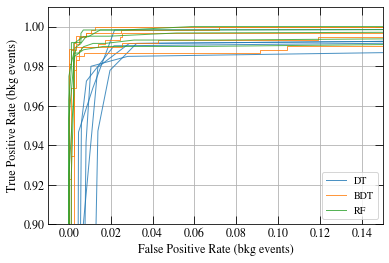

In [62]:
for i, clf in enumerate(clfs):
    for j in range(kf.n_splits):
        plt.plot(fpr[i][j], tpr[i][j],
                 color=color_train[i],
                 lw=1,
                 label=label_clf[i] if not j else '',
                 alpha=0.8
                )
    
plt.xlabel("False Positive Rate (bkg events)")
plt.ylabel("True Positive Rate (bkg events)")
plt.plot([0,1], [0,1], ls='--', color='k')
plt.legend()
plt.grid()
plt.gca().set_ylim(0.9,1.01)
plt.gca().set_xlim(-0.01,0.15)
plt.savefig(f"../../../sandbox/plots/roc_{prefix_plot:s}.pdf")

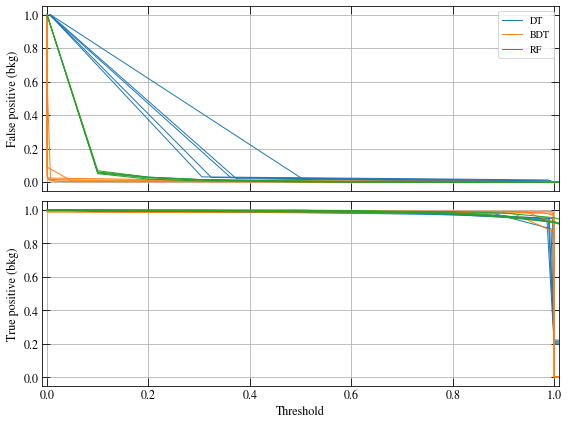

In [63]:
fig = plt.figure(figsize=(8,6), tight_layout=True)

ax_fpr = plt.subplot(211)
ax_tpr = plt.subplot(212)

for i, clf in enumerate(clfs):
    for j in range(kf.n_splits):
        ax_fpr.plot(thr[i][j], fpr[i][j],
                    color=color_train[i],
                    lw=1, label=label_clf[i] if not j else '')
        
        ax_tpr.plot(thr[i][j], tpr[i][j],
                   color=color_train[i],
                   lw=1)
    

ax_tpr.set_xlabel("Threshold")
ax_tpr.set_ylabel("True positive (bkg)")
ax_fpr.set_ylabel("False positive (bkg)")
ax_fpr.grid()
ax_fpr.legend()
ax_tpr.grid()
ax_tpr.set_xlim(-0.01,1.01)
ax_fpr.set_xlim(-0.01,1.01)
ax_fpr.tick_params(labelbottom=False)

fig.subplots_adjust(hspace=0, wspace=0)
fig.savefig(f"../../../sandbox/plots/thr_vs_fpr_tpr_{prefix_plot:s}.pdf")

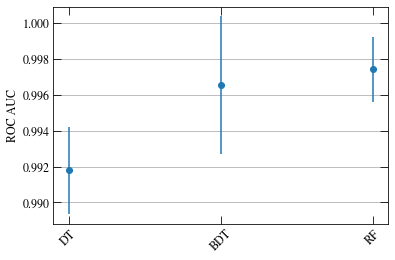

In [64]:
ax = plt.subplot(1,1,1)

roc_auc = np.array(roc_auc)
plt.errorbar(range(roc_auc.shape[0]), roc_auc.mean(axis=1),
             yerr=np.sqrt(roc_auc.var(axis=1)),
             marker='o', ls='none'
             )
plt.grid(axis='y')
plt.xticks([0,1,2],['DT','BDT','RF'], rotation=45.)
plt.ylabel('ROC AUC')
    
plt.savefig(f"../../../sandbox/plots/roc_auc_{prefix_plot:s}.pdf")

### To Do

* Perform comparisons via $K$-fold cross validations
* Perform selection of best hyper parameters via cross validation
* Plot a learning curve, to see whether more data would help
* Try deep learning directly on input